# Modelos a implementar

En esta situacion vamos a implementar algunos de los modelos de aprendizaje supervisado y comparar cuales quedan mejor adaptadas para el problema a partir de métricas y definiciones que se determinarán durante el desarrollo.

# 1. K-Vecinos Cercanos

In [30]:
#Importacion de las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [31]:
#Cargamos el dataframe procesado de nuestro repositorio de GitHub
#url = 'https://raw.githubusercontent.com/Axumis/Parcial_Aprendizaje_Automatico/refs/heads/main/data/processed/dataset_con_riesgo.csv'
url= 'https://raw.githubusercontent.com/Axumis/Parcial_Aprendizaje_Automatico/refs/heads/main/data/processed/dataset_con_riesgo_2.csv'
df = pd.read_csv(url)

#Mostramos el dataframe
df

,Temperatura_[°C],Humedad_relativa_[%],Precipitación_[mm],Velocidad_viento_[km/h],Riesgo
0,6.273000,63.0,0.0,20.780453,Moderado
1,6.273000,64.0,0.0,20.380579,Moderado
2,7.023000,60.0,0.0,22.530937,Alto
3,8.023000,55.0,0.0,27.193705,Alto
4,8.672999,53.0,0.0,26.400545,Alto
...,...,...,...,...,...
22022,-1.327000,84.0,0.0,3.545589,Bajo
22023,-1.827000,88.0,0.0,3.826853,Bajo
22024,-2.227000,91.0,0.0,4.104631,Bajo
22025,-2.177000,92.0,0.0,3.826853,Bajo


Preparamos el dataset

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
X= df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]']].values
y= df['Riesgo'].values

# 1. Codificamos las etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#2. Dividimos los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Escalamos las features tanto de entrenamiento como de prueba
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicamos PCA
pca = PCA(n_components=2) # Reducimos a 2 dimensiones para el grafico
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Creamos el modelo

In [4]:
# 5. Entrenamos y predecimos
k = 3 #Asignamos un valor de k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=3)

Visualizamos el entrenamiento (Utilizando PCA para reducir dimensiones)

Gráfica de la Clasificación Obtenida

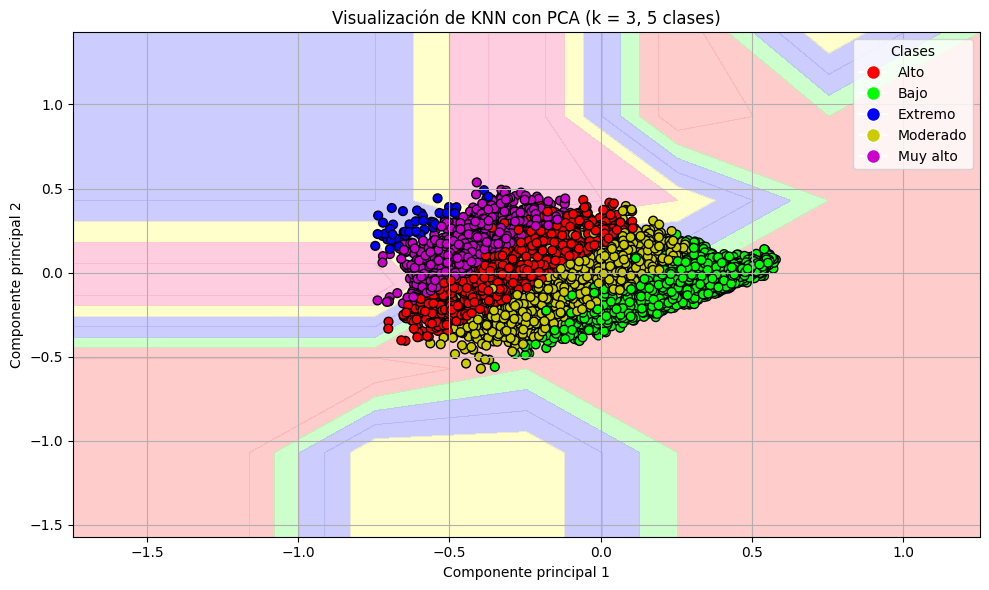

In [5]:
# Crear malla para frontera de decisión
h = 0.5
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Colores
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFFAA', '#FFAACC'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#CCCC00', '#CC00CC'])

# Graficar
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train,
                      cmap=cmap_bold, edgecolor='k', s=40)

# Crear leyenda con los nombres originales de las clases
legend_labels = le.inverse_transform(np.unique(y_train))
legend_colors = [scatter.cmap(scatter.norm(i)) for i in np.unique(y_train)]
patches = [plt.Line2D([0], [0], marker='o', color='w',
                      label=label, markerfacecolor=color, markersize=10)
           for label, color in zip(legend_labels, legend_colors)]

plt.legend(handles=patches, title="Clases")
plt.title(f"Visualización de KNN con PCA (k = {k}, {len(legend_labels)} clases)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


Predicciones del modelo

In [6]:
# Predicciones
y_pred = knn.predict(X_test_pca)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(np.unique(y_encoded))))

Accuracy: 0.93

Reporte de clasificación:
              precision    recall  f1-score   support

        Alto       0.91      0.94      0.92      1301
        Bajo       0.98      0.94      0.96      1979
     Extremo       0.89      0.89      0.89        18
    Moderado       0.91      0.92      0.92      1831
    Muy alto       0.89      0.95      0.92       378

    accuracy                           0.93      5507
   macro avg       0.92      0.93      0.92      5507
weighted avg       0.93      0.93      0.93      5507



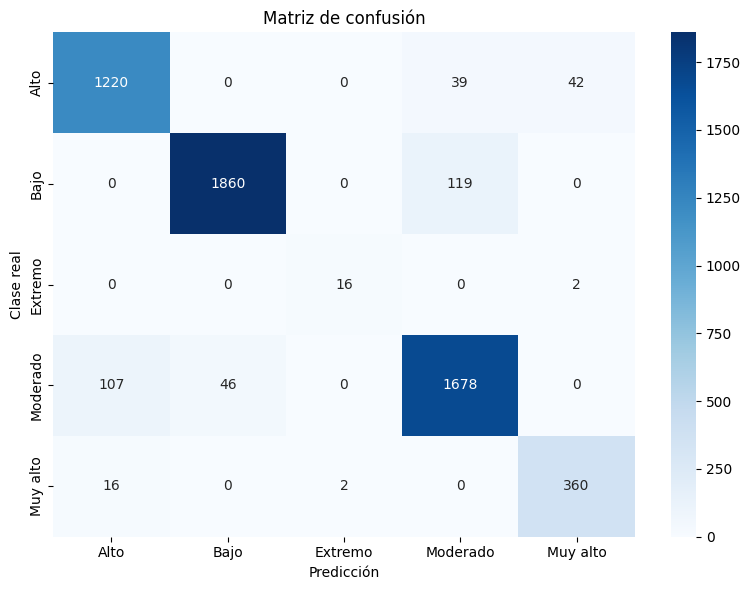

In [7]:
# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.inverse_transform(np.unique(y_encoded)),
            yticklabels=le.inverse_transform(np.unique(y_encoded)))
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()

Creamos el Modelo 2da opcion sin usar PCA

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
X= df[['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]']].values
y= df['Riesgo'].values


#1. Dividimos los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Escalamos las features tanto de entrenamiento como de prueba
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# 5. Entrenamos y predecimos
k = 2 #Asignamos un valor de k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [34]:
# Predicciones
y_pred = knn.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Reporte completo
print("\nReporte de clasificación:")
clases = ['Bajo', 'Moderado', 'Alto', 'Muy alto', 'Extremo']
print(classification_report(y_test, y_pred, labels=clases, target_names=clases))

Accuracy: 0.96

Reporte de clasificación:
              precision    recall  f1-score   support

        Bajo       0.98      0.99      0.98      1979
    Moderado       0.98      0.92      0.95      1831
        Alto       0.91      0.98      0.95      1301
    Muy alto       0.96      0.92      0.94       378
     Extremo       0.94      0.94      0.94        18

    accuracy                           0.96      5507
   macro avg       0.95      0.95      0.95      5507
weighted avg       0.96      0.96      0.96      5507



<Figure size 1000x600 with 0 Axes>

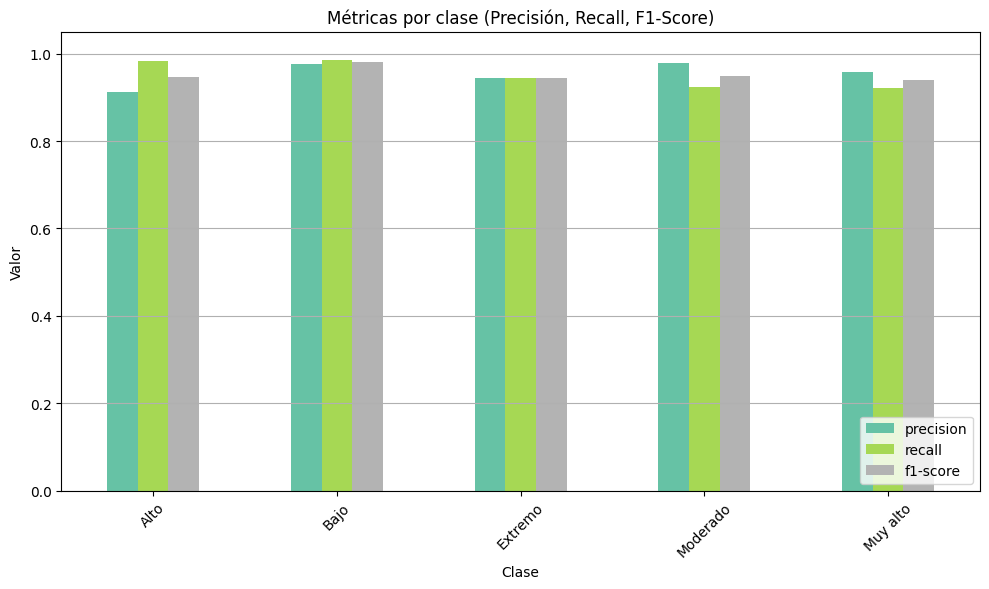

In [35]:
# Obtener el reporte de clasificación como diccionario
report = classification_report(y_test, y_pred, output_dict=True)

# Convertir a DataFrame y eliminar la fila 'accuracy', 'macro avg' y 'weighted avg'
df_report = pd.DataFrame(report).transpose()
df_clases = df_report.iloc[:-3]  # solo las clases

# Plot
plt.figure(figsize=(10, 6))
df_clases[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6), colormap='Set2')

plt.title("Métricas por clase (Precisión, Recall, F1-Score)")
plt.xlabel("Clase")
plt.ylabel("Valor")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()


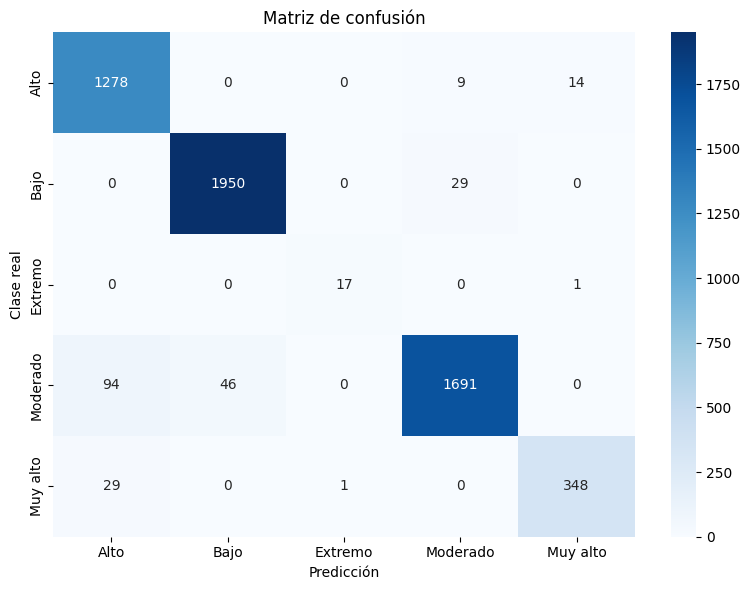

In [36]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener etiquetas de clase únicas ordenadas
labels = sorted(np.unique(y_test))

# Graficar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()

In [37]:
# Una muestra manual (reemplazá con tus valores)
nueva_muestra = [[7, 95, 0.8, 24]]  # ejemplo: 4 features
muestra = [[5, 95, 4.5, 3]]

In [38]:
# Escalar
nueva_muestra_escalada = scaler.transform(nueva_muestra)
nueva_muestra_escalada2 = scaler.transform(muestra)

In [39]:
# Predecir la clase
prediccion = knn.predict(nueva_muestra_escalada)
prediccion2 = knn.predict(nueva_muestra_escalada2)

# Mostrar resultado
print("Clase predicha:", prediccion[0], prediccion2[0])

Clase predicha: Bajo Bajo


# Usando Arbol de decision

In [41]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
# Suponiendo que tus variables predictoras están en X y la variable objetivo en y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [43]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

Accuracy: 0.98

Reporte de clasificación:
              precision    recall  f1-score   support

        Alto       0.97      0.98      0.98      1342
        Bajo       0.99      0.99      0.99      1948
     Extremo       0.79      0.85      0.81        13
    Moderado       0.98      0.98      0.98      1783
    Muy alto       0.97      0.96      0.97       421

    accuracy                           0.98      5507
   macro avg       0.94      0.95      0.95      5507
weighted avg       0.98      0.98      0.98      5507



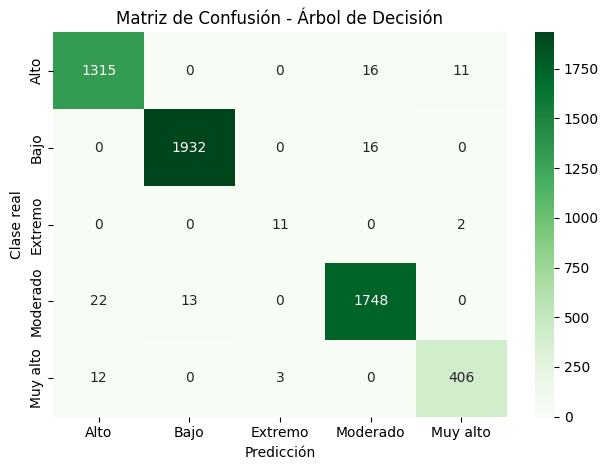

In [44]:
y_pred = tree.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=tree.classes_, yticklabels=tree.classes_)
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.tight_layout()
plt.show()


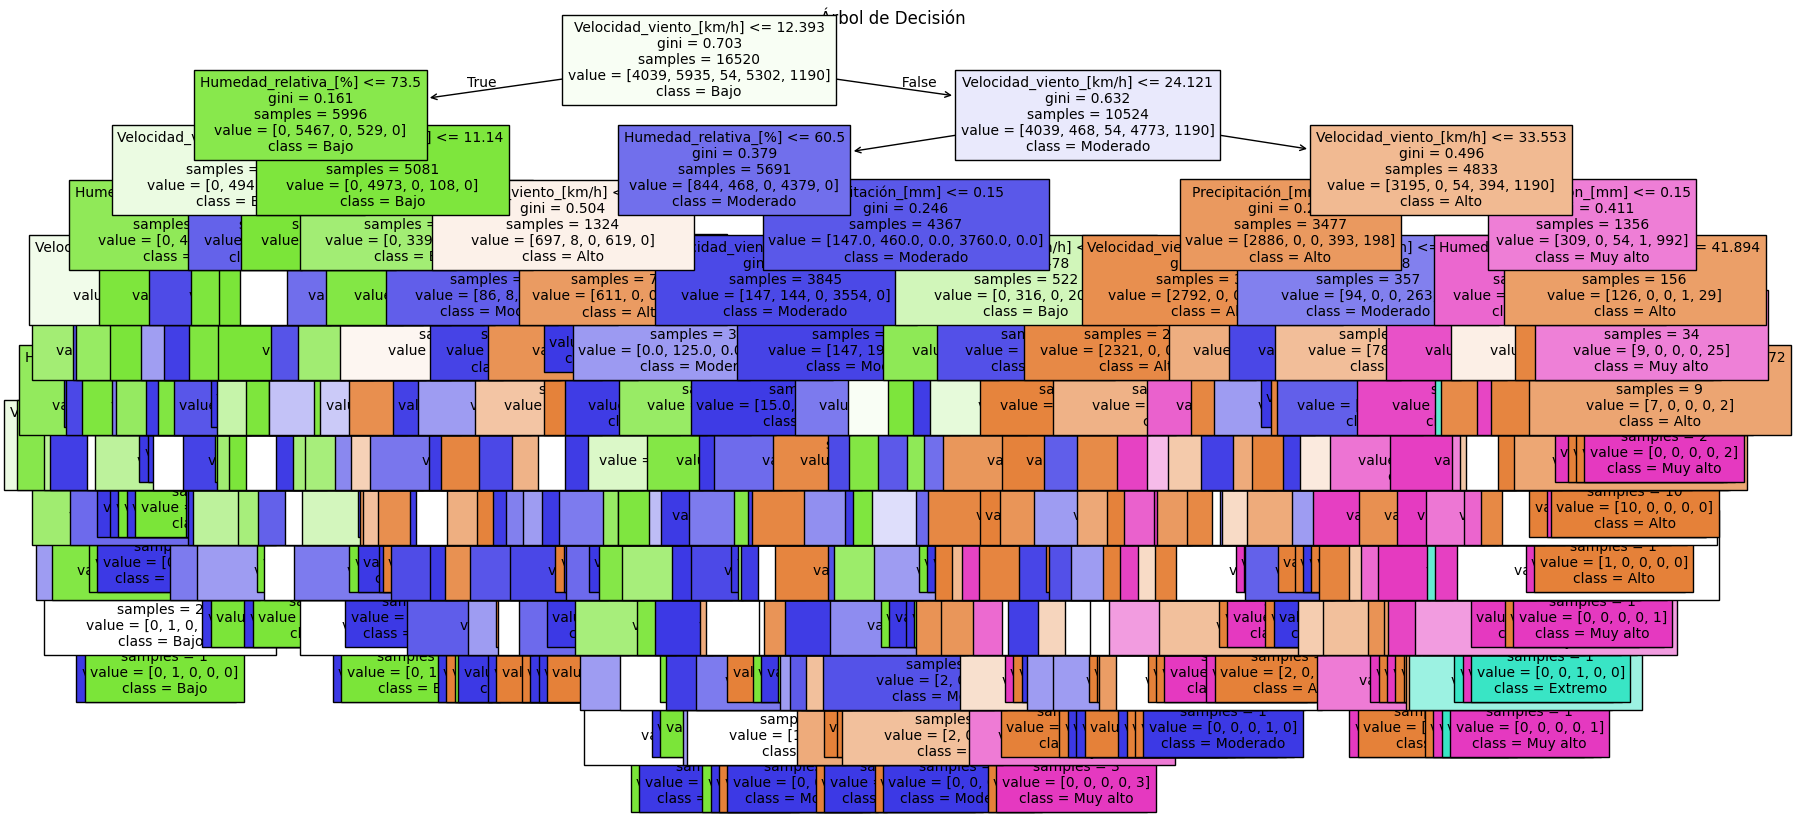

In [47]:
feature_names = ['Temperatura_[°C]', 'Humedad_relativa_[%]', 'Precipitación_[mm]', 'Velocidad_viento_[km/h]']
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=feature_names, class_names=tree.classes_, fontsize=10)
plt.title("Árbol de Decisión")
plt.show()


In [48]:
# Por ejemplo, insertás valores manualmente en orden según tus columnas
nueva= [[7, 95, 0.8, 24]]  # ejemplo: 4 features

# Predecir clase
prediccion = tree.predict(nueva)
print("Predicción del riesgo:", prediccion[0])


Predicción del riesgo: Moderado
